### CS 421 PROJECT

In [97]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.multiclass import OneVsRestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.metrics import roc_curve, auc, confusion_matrix
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
import seaborn as sns

In [98]:
# Load the dataset
data = np.load("first_batch_multi_labels.npz")
X = data["X"]
y = data["yy"]

# Create DataFrames
df_X = pd.DataFrame(X, columns=["user", "item", "rating"])
df_y = pd.DataFrame(y, columns=["user", "label"])

# Feature Engineering
# Group by user and compute aggregated features
df_user_features = df_X.groupby('user').agg(
    mean_rating=('rating', 'mean'),
    count_dislike=('rating', lambda x: (x == -10).sum()),
    count_neutral=('rating', lambda x: (x == 0).sum()),
    count_like=('rating', lambda x: (x == 10).sum()),
    count_watched=('rating', lambda x: (x == 1).sum()),
    total_interactions=('rating', 'count')
).reset_index()

# Merge the features with the labels
df_merged = pd.merge(df_user_features, df_y, on='user')

# Features and Labels
X_features = df_merged.drop(columns=['user', 'label'])
y_labels = df_merged['label']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_features, y_labels, test_size=0.2, random_state=42, stratify=y_labels)

# Handling imbalance using SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Model Training with Random Forest in One-vs-Rest scheme
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
ovr_model = OneVsRestClassifier(rf_model)

# Use a pipeline for scaling and modeling
pipeline = make_pipeline(StandardScaler(), ovr_model)
pipeline.fit(X_resampled, y_resampled)

# Predictions
y_pred_prob = pipeline.predict_proba(X_test)

# Evaluate with AUC for each class (Normal: class 0, Anomaly 1: class 1, Anomaly 2: class 2)
auc_scores = roc_auc_score(y_test, y_pred_prob, average=None, multi_class='ovr')

# Print the AUC scores for each class
print(f"AUC Scores: Normal (Class 0): {auc_scores[0]:.4f}, Anomaly 1 (Class 1): {auc_scores[1]:.4f}, Anomaly 2 (Class 2): {auc_scores[2]:.4f}")

AUC Scores: Normal (Class 0): 0.9104, Anomaly 1 (Class 1): 0.8583, Anomaly 2 (Class 2): 0.9293


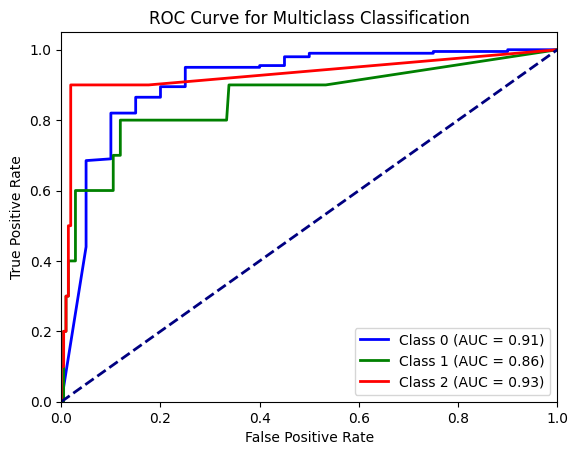

In [99]:
# Binarize the output labels for multiclass ROC curve calculation
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2])
n_classes = y_test_binarized.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure()
colors = ['blue', 'green', 'red']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multiclass Classification')
plt.legend(loc="lower right")
plt.show()

[[190   6   4]
 [  5   5   0]
 [  1   0   9]]


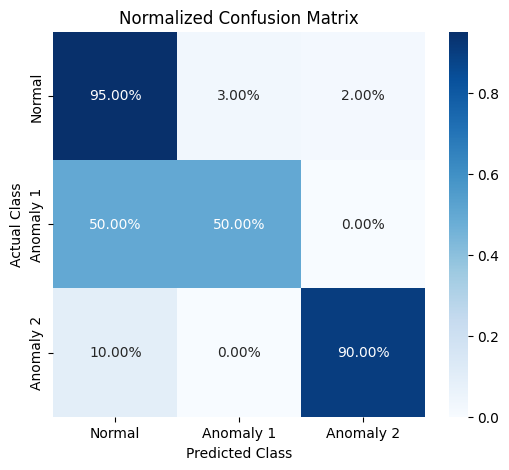

In [106]:
# Make predictions (convert probabilities to class labels)
y_pred = pipeline.predict(X_test)

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print(conf_matrix)

# Normalize the confusion matrix by the number of samples in each class
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# Display the normalized confusion matrix using Seaborn
plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix_normalized, annot=True, fmt='.2%', cmap='Blues', 
            xticklabels=['Normal', 'Anomaly 1', 'Anomaly 2'], 
            yticklabels=['Normal', 'Anomaly 1', 'Anomaly 2'])

plt.title("Normalized Confusion Matrix")
plt.xlabel("Predicted Class")
plt.ylabel("Actual Class")
plt.show()

In [101]:
# Set the hyperparameters to tune
# param_grid = {
#     'onevsrestclassifier__estimator__n_estimators': [100, 200, 500],
#     'onevsrestclassifier__estimator__max_depth': [10, 20, None],
#     'onevsrestclassifier__estimator__min_samples_split': [2, 5, 10],
#     'onevsrestclassifier__estimator__min_samples_leaf': [1, 2, 4],
#     'onevsrestclassifier__estimator__max_features': ['sqrt', 'log2', None],
#     'onevsrestclassifier__estimator__bootstrap': [True, False]
# }


param_grid = {
    'onevsrestclassifier__estimator__n_estimators': [500],
    'onevsrestclassifier__estimator__max_depth': [None],
    'onevsrestclassifier__estimator__min_samples_split': [2],
    'onevsrestclassifier__estimator__min_samples_leaf': [1],
    'onevsrestclassifier__estimator__max_features': ['sqrt'],
    'onevsrestclassifier__estimator__bootstrap': [True]
}

# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, 
                           scoring='roc_auc_ovr', cv=3, n_jobs=-1, verbose=2)

# Fit the grid search to the data
grid_search.fit(X_resampled, y_resampled)

# Print the best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

# Evaluate on test set
best_model = grid_search.best_estimator_
y_pred_prob_best = best_model.predict_proba(X_test)

# AUC Scores
best_auc_scores = roc_auc_score(y_test, y_pred_prob_best, average=None, multi_class='ovr')
print(f"Best AUC Scores: Normal (Class 0): {best_auc_scores[0]:.4f}, Anomaly 1 (Class 1): {best_auc_scores[1]:.4f}, Anomaly 2 (Class 2): {best_auc_scores[2]:.4f}")

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END onevsrestclassifier__estimator__bootstrap=True, onevsrestclassifier__estimator__max_depth=None, onevsrestclassifier__estimator__max_features=sqrt, onevsrestclassifier__estimator__min_samples_leaf=1, onevsrestclassifier__estimator__min_samples_split=2, onevsrestclassifier__estimator__n_estimators=500; total time=   1.9s
[CV] END onevsrestclassifier__estimator__bootstrap=True, onevsrestclassifier__estimator__max_depth=None, onevsrestclassifier__estimator__max_features=sqrt, onevsrestclassifier__estimator__min_samples_leaf=1, onevsrestclassifier__estimator__min_samples_split=2, onevsrestclassifier__estimator__n_estimators=500; total time=   1.9s
[CV] END onevsrestclassifier__estimator__bootstrap=True, onevsrestclassifier__estimator__max_depth=None, onevsrestclassifier__estimator__max_features=sqrt, onevsrestclassifier__estimator__min_samples_leaf=1, onevsrestclassifier__estimator__min_samples_split=2, onevsrestclassifier_

In [102]:
# Best Hyperparameters: {'onevsrestclassifier__estimator__bootstrap': True, 'onevsrestclassifier__estimator__max_depth': None, 'onevsrestclassifier__estimator__max_features': 'sqrt', 'onevsrestclassifier__estimator__min_samples_leaf': 1, 'onevsrestclassifier__estimator__min_samples_split': 2, 'onevsrestclassifier__estimator__n_estimators': 500}
# Best AUC Scores: Normal (Class 0): 0.9124, Anomaly 1 (Class 1): 0.8674, Anomaly 2 (Class 2): 0.9724

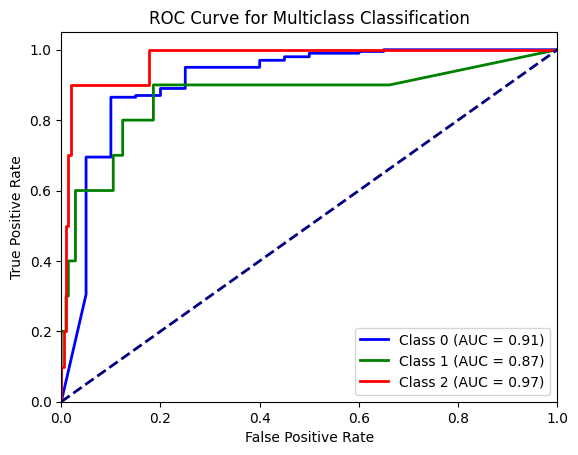

In [103]:
y_pred_prob_best = best_model.predict_proba(X_test)

# Binarize the output labels for multiclass ROC curve calculation
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2])
n_classes = y_test_binarized.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred_prob_best[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure()
colors = ['blue', 'green', 'red']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multiclass Classification')
plt.legend(loc="lower right")
plt.show()

[[190   6   4]
 [  5   5   0]
 [  2   0   8]]


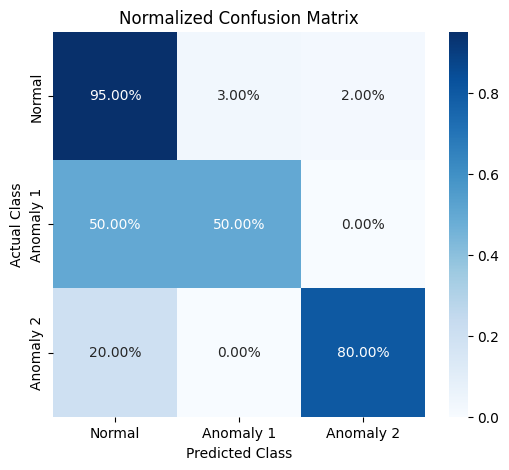

In [107]:
# Make predictions (convert probabilities to class labels)
y_pred = best_model.predict(X_test)

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

print(conf_matrix)

# Normalize the confusion matrix by the number of samples in each class
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# Display the normalized confusion matrix using Seaborn
plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix_normalized, annot=True, fmt='.2%', cmap='Blues', 
            xticklabels=['Normal', 'Anomaly 1', 'Anomaly 2'], 
            yticklabels=['Normal', 'Anomaly 1', 'Anomaly 2'])

plt.title("Normalized Confusion Matrix")
plt.xlabel("Predicted Class")
plt.ylabel("Actual Class")
plt.show()